In [38]:
from typing import Any, Callable, List, Optional, Type, Union, Tuple, Dict
from torch import Tensor

import torch
from torch import nn, optim, mps
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
from tqdm import tqdm
import copy

from models.resnets import resnet
from utils.network_utils import count_parameters, count_FLOPS, calculate_storage_in_mb
from utils.bayesian_utils import bayes_eval, bayes_forward

## Prepare dataset

In [2]:
classes = [
    "plane",
    "car",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
]

CLASS_MAP = {i: classes[i] for i in range(len(classes))}
FILL_PIX = None
DEVICE = 'mps' if torch.backends.mps.is_available() else 'cpu'

In [29]:
class ToDevice(object):
    def __init__(self, device):
        self.device = device

    def __call__(self, sample):
        return sample.to(self.device)


# import dataset from torch
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        ToDevice(DEVICE),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)

trainset = torchvision.datasets.CIFAR10(
    root="./data", train=True, download=True, transform=transform
)

testset = torchvision.datasets.CIFAR10(
    root="./data", train=False, download=True, transform=transform
)


def train_val_split(train_set, train_ratio=0.8, deterministic=True):
    """
    Split the training set into training and validation set
    """
    if deterministic:
        torch.manual_seed(0)
    train_size = int(train_ratio * len(train_set))
    val_size = len(train_set) - train_size
    train_set, val_set = torch.utils.data.random_split(
        train_set, [train_size, val_size]
    )
    return train_set, val_set


trainset, valset = train_val_split(trainset, train_ratio=0.9, deterministic=True)

datasets = {"train": trainset, "val": valset, "test": testset}

print("Train set size: ", len(trainset))
print("Validation set size: ", len(valset))
print("Test set size: ", len(testset))

Files already downloaded and verified
Files already downloaded and verified
Train set size:  45000
Validation set size:  5000
Test set size:  10000


### Preview images

In [30]:
def imshow_image(img) -> None:
    plt.imshow(img.cpu().permute(1, 2, 0))
    plt.axis("off")


def show_cifar_images(
    grid_size: Tuple[int, int],
    show_labels: bool = True,
    dataset: str = None,
    preds: List[int] = None,
):
    """
    Show a grid of images from CIFAR10 dataset
    """
    if preds is not None:
        assert len(preds) == grid_size[0] * grid_size[1]
    if dataset is None:
        dataset = testset
    n1, n2 = grid_size
    plt.subplots(n1, n2, figsize=(n2 * 1.5, n1 * 1.5))
    for i in range(n2):
        for j in range(n1):
            idx = i * grid_size[0] + j
            img, label = dataset[idx]
            img = img / 2 + 0.5  # unnormalize
            plt.subplot(n1, n2, idx + 1)
            imshow_image(img)
            if show_labels:
                plt.title(classes[label])
            if preds is not None:
                if label != preds[idx]:
                    color = "red"
                plt.title(f"{classes[label]}-{classes[preds[idx]]}", color=color)
    plt.tight_layout()
    plt.show()

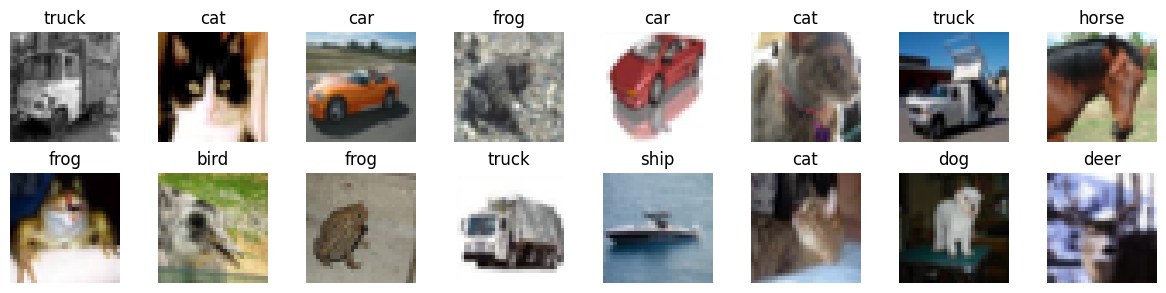

In [31]:
show_cifar_images((2, 8), show_labels=True, dataset=valset)
# to show images with predictions:
# show_cifar_images((2, 8), show_labels=True, dataset=testset, preds=preds)

## ResNet

In [13]:
def compute_expected_layers(model: nn.Module) -> int:
    """
    Compute the expected depth with stochastic depth
    """
    sd_config = model.sd_config
    num_layers = sum([1 - p for p in sd_config.probs])
    # multiply by 2 because conv + bn, +2 for first conv and bn
    num_layers = num_layers * 2 + 2
    return num_layers

In [32]:
resnet18 = resnet("resnet18", num_classes=10)

# load resnet18 pretrained on ImageNet
# resnet18_torch = torchvision.models.resnet.resnet18(num_classes=10)

print(f"Number of parameters: {count_parameters(resnet18, print_table=False)/1e6 :.3f} M")
print(f"Parameter in MB: {calculate_storage_in_mb(resnet18):.3f}")
print(f"Number of expected layers: {compute_expected_layers(resnet18)}")
# print(f"Number of FLOPS: {count_FLOPS(resnet18, input_dim=(32, 32))/1e9:.3f} GFLOPS")

del(resnet18)

Number of parameters: 11.182 M
Buffer size: 0.037 MB
Parameter in MB: 42.691
Number of expected layers: 18.0


In [ ]:
dummy_input = torch.randn(16, 3, 32, 32)

dummy_output = resnet18(dummy_input)

## Utils & Metrics
to be refactored

In [34]:
def _parse_scheduler(
    optimizer, scheduler_name: str, total_epochs=Optional[float], **kwargs
):
    """
    Parse the scheduler name and return the scheduler
    """
    if scheduler_name == "poly":
        # total_iters = self.total_epochs * math.ceil(len(self.dataloaders['train'].dataset)/self.batch_size)
        total_iters = total_epochs
        scheduler = optim.lr_scheduler.PolynomialLR(
            optimizer, total_iters=total_iters, power=kwargs.get("power", 0.9)
        )
    elif scheduler_name == "exp":
        scheduler = optim.lr_scheduler.ExponentialLR(
            optimizer, gamma=kwargs.get("gamma", 0.9)
        )
    else:
        scheduler = optim.lr_scheduler.ConstantLR(
            optimizer, total_iters=total_epochs, factor=1
        )
    return scheduler


def _parse_loss(loss_name: str):
    """
    Parse the loss function name and return the loss function
    """
    if loss_name == "Focal":
        criterion = FocalLoss()
    elif loss_name == "CE":
        criterion = CELoss()
    else:
        raise ValueError(f"Loss function {criterion} not supported")
    return criterion

In [53]:
class FocalLoss(object):
    def __init__(self):
        pass

    def __call__(self, y_true, y_pred):
        """
        Args
        ----------
        y_true: torch.tensor (n, 1, 224, 224)
        y_pred: torch.tensor (n, c, 224, 224)
        """
        # place mask over placeholder pixels (loss do not propagate through them)
        mask = torch.where(y_true == FILL_PIX, zeros_like(y_true), ones_like(y_true))

        y_true = (y_true * mask).squeeze(dim=1)
        # one-hot encode labels
        y_true_one_hot = (
            nn.functional.one_hot(y_true.long(), num_classes=NUM_CLASSES)
            .float()
            .permute(0, 3, 1, 2)
        )

        y_pred = y_pred * mask
        focal_loss = torchvision.ops.sigmoid_focal_loss(
            y_pred, y_true_one_hot, reduction="none"
        )
        loss = (focal_loss * mask).sum() / (mask.sum() + 1e-16)

        return loss


class CELoss(object):
    def __init__(self):
        ignore_index = FILL_PIX if FILL_PIX is not None else -100
        self.CE_loss = torch.nn.CrossEntropyLoss(
            ignore_index=ignore_index, reduction="mean"
        )
        pass

    def __call__(self, y_true, y_pred):
        """
        Args
        ----------
        y_true: torch.tensor (n, 1, 224, 224) or (n, 1)
        y_pred: torch.tensor (n, c, 224, 224) or (n, c)
        """
        y_true = y_true.to(DEVICE)
        if len(y_true.shape) == 4:
            y_true = y_true.squeeze(dim=1)
        loss = self.CE_loss(y_pred, y_true.long())
        return loss

In [43]:
class AccuracyMetric(object):
    def __init__(self, metrics=["acc"]):
        self.compute_acc = "acc" in metrics
        self.compute_iou = "iou" in metrics

    def __call__(self, confusion_matrix: Tensor) -> dict:
        """
        Args
        ---------
        confusion_matrix: Tensor (c x c)
        n: int
        """
        cm = confusion_matrix
        num_classes = cm.shape[0]
        metrics = {}

        TPs = torch.diagonal(cm, 0)
        FPs = torch.sum(cm, dim=0) - TPs
        FNs = torch.sum(cm, dim=1) - TPs

        if self.compute_acc:
            accs = TPs / (TPs + FNs)
            avg_acc = accs.mean()
            for c in range(num_classes):
                metrics[f"acc/{CLASS_MAP[c]}"] = accs[c].item()
            metrics["acc/avg"] = avg_acc.item()
            metrics["acc/global"] = TPs.sum().item() / (cm.sum().item() + 1e-16)

        if self.compute_iou:
            ious = TPs / (FNs + FPs + TPs)
            miou = ious.mean()

            for c in range(num_classes):
                metrics[f"iou/{CLASS_MAP[c]}"] = ious[c].item()
            metrics["iou/mean"] = miou.item()

        return metrics


def get_confusion_matrix(y_gt: Tensor, y_pred: Tensor, num_classes: int) -> Tensor:
    """
    Compute the bins to update the confusion matrix with, code adapted from torchmetrics
    Args
    ----------
    y_gt: torch.tensor (n, 1, 224, 224)
    y_pred: torch.tensor (n, 1, 224, 224)
    num_classes: int

    Returns
    ----------
    confusion_matrix: torch.tensor(num_classes, num_classes)
    """

    unique_mapping = y_gt.to(torch.long) * num_classes + y_pred.to(torch.long)
    bins = torch.bincount(
        unique_mapping.flatten(), minlength=num_classes * (num_classes + 1)
    )
    # print(bins)
    # print(bins.reshape(12, 11))
    # print(bins.reshape(12, 11)[0, :])

    return bins[: num_classes**2].reshape(num_classes, num_classes)

## Training Manager

In [58]:
class TrainingManager:
    def __init__(self, config, datasets):
        self.datasets = datasets
        self.config = config

        self._load()

    def _load(self) -> None:
        # read config
        self.T = self.config.get("T", 10)
        self.batch_size = self.config.get("batch_size", 16)
        self.input_dim = self.config.get("input_dim", (32, 32))
        self.total_epochs = self.config.get("total_epochs", 100)
        self.weight_decay = self.config.get("weight_decay", 1e-4)
        self.baseline_lr = self.config.get("lr", 1e-4)
        self.patience = self.config.get("patience", 20)
        self.track_metrics = self.config.get("track_metrics", ["loss"])
        self.num_classes = self.config.get("num_classes", 10)

        # initiate dataloader
        self.dataloaders = {
            "train": DataLoader(
                self.datasets["train"], batch_size=self.batch_size, shuffle=True
            ),
            "val": DataLoader(self.datasets["val"], batch_size=1, shuffle=False),
            "test": DataLoader(self.datasets["test"], batch_size=1, shuffle=False),
        }

        # initiate model
        self.net = resnet(
            resnet_name=self.config["model"],
            num_classes=self.config.get("num_classes", 10),
            dropout_mode=self.config.get("dropout_mode", "none"),
            dropout_p=self.config.get("dropout_p", 0.0),
            sd_mode=self.config.get("sd_mode", "none"),
            sd_p=self.config.get("sd_p", 0.0),
        )
        self.net.to(DEVICE)

        # initiate loss function and metric
        self.criterion = _parse_loss(self.config.get("loss", "CE"))
        self.metric = AccuracyMetric()

        # initiate optimizer and scheduler
        self.optimizer = torch.optim.RMSprop(
            self.net.parameters(), weight_decay=self.weight_decay, lr=self.baseline_lr
        )
        self.scheduler = _parse_scheduler(
            self.optimizer, self.config.get("scheduler", "none"), self.total_epochs
        )

        # initialize history
        self.epoch = 0
        self.history = {"lr": []}

        for split in ["train", "val", "val_b"]:
            self.history[f"loss/{split}"] = []
            self.history[f"acc/avg/{split}"] = []
            self.history[f"acc/global/{split}"] = []
            for c in CLASS_MAP.values():
                self.history[f"acc/{c}/{split}"] = []

        self.history["best_val_loss"] = 999
        self.history["best_val_acc"] = 0
        self.history["best_epoch"] = 0
        self.patience_count = 0

    def _check_early_stop(self, min_epochs: int = 10) -> bool:
        """
        Checks for early stop and updates best net, returns early stop state
        """
        if self.epoch < min_epochs or len(self.history["loss/val"]) <= 1:
            return False

        update_best = False
        loss = self.history["loss/val"][-1]
        acc = self.history["acc/avg/val"][-1]
        curr_min_loss = self.history.get("best_val_loss", 999)
        curr_max_acc = self.history.get("best_val_acc", 0)

        # compare loss and acc to current best
        if "loss" in self.track_metrics and loss < curr_min_loss:
            print(f"loss decreased by {(curr_min_loss-loss)/curr_min_loss*100 :.3f} %")
            self.history["best_val_loss"] = loss
            update_best = True
        if "acc" in self.track_metrics and acc > curr_max_acc:
            print(
                f"acc increased by {(acc-curr_max_acc)/(curr_max_acc+1e-16)*100 :.3f} %"
            )
            self.history["best_val_acc"] = acc
            update_best = True

        if loss > curr_min_loss and acc < curr_max_acc:
            self.patience_count += 1

        # update best net
        if update_best:
            print("saving best net...")
            self.best_net = copy.deepcopy(self.net)
            self.history["best_epoch"] = self.epoch
            self.patience_count = 0

        if self.patience_count >= self.patience:
            print(
                f"Acc(c) or miou have not improved for {self.patience} epochs, terminate training"
            )
            return True

        return False

    def evaluate(
        self,
        set: str = "test",
        bayes_mode: bool = True,
        T: Optional[int] = None,
        **kwargs,
    ) -> Tuple[float, Dict[str, float]]:
        """
        Evaluate the model on a given set
        """
        self.net.eval()
        buffer_tensor = None
        if bayes_mode:
            self.net.set_bayes_mode(True)
            T = self.T if T is None else T
            h, w = self.config["input_dim"]
            buffer_tensor = torch.empty(
                size=(T, 3, h, w), dtype=torch.float32, device=DEVICE
            )
        else:
            self.net.set_bayes_mode(False)
            T = 0

        # create temporary dict to hold epoch results for train set
        loss = 0
        confusion_matrix = torch.zeros(
            (self.num_classes, self.num_classes), device=DEVICE
        )

        with torch.no_grad():
            for X_batch, y_batch in tqdm(self.dataloaders[set]):
                # force batch size to be 1
                for x, y in zip(X_batch, y_batch):
                    # forward pass
                    y = y.to(DEVICE)
                    y_logits, y_pred = bayes_eval(
                        self.net, x, T, buffer=buffer_tensor
                    )
                    # compute loss
                    loss += self.criterion(y.squeeze(0), y_logits).item()
                    # update confusion matrix
                    confusion_matrix += get_confusion_matrix(
                        y.squeeze(0), y_pred, self.num_classes
                    )

        # compute loss and accuracy
        loss /= len(self.dataloaders[set].dataset)
        accs = self.metric(confusion_matrix)

        return loss, accs

    def train(self, epochs, eval_mode="bayes") -> None:
        """
        Main training loop
        Args:
            epochs: number of epochs to train
            eval_mode: mode to evaluate the model, can be "regular", "bayes", or "all"
        """
        torch.cuda.empty_cache()  # helps clearing RAM
        for e in range(epochs):
            self.net.train()
            # stochastic regularization should always be on during training
            self.net.set_bayes_mode(True)
            # create temporary dict to hold epoch results for train set
            train_loss = 0
            confusion_matrix = torch.zeros(
                (self.num_classes, self.num_classes), device=DEVICE
            )

            for X_batch, y_batch in tqdm(self.dataloaders["train"]):
                y_batch=y_batch.to(DEVICE)
                self.optimizer.zero_grad()
                # forward pass
                y_logits = self.net(X_batch)
                # compute loss
                loss = self.criterion(y_batch, y_logits)
                # back prop
                loss.backward()
                # update parameters
                self.optimizer.step()
                # update loss
                batch_size = X_batch.shape[0]
                train_loss += loss.item() * batch_size
                # update confusion matrix
                y_pred = torch.argmax(y_logits, 1, keepdim=True)
                confusion_matrix += get_confusion_matrix(
                    y_batch, y_pred, self.num_classes
                )
            self.scheduler.step()

            # compute average train loss and accuracy
            n_train = len(self.dataloaders["train"].dataset)
            train_loss /= n_train
            accs = self.metric(confusion_matrix)
            self._log_results("train", train_loss, accs)

            # compute validation loss and accuracy
            val_loss, val_accs, val_loss_b, val_accs_b = None, None, None, None
            if eval_mode == "regular" or eval_mode == "all":
                val_loss, val_accs = self.evaluate("val", False)
            if eval_mode == "bayes" or eval_mode == "all":
                val_loss_b, val_accs_b = self.evaluate("val", True)

            self._log_results("val", val_loss, val_accs)
            self._log_results("val_b", val_loss_b, val_accs_b)

            self.history["lr"].append(self.scheduler.get_last_lr()[0])

            # check for early stop
            early_stop = self._check_early_stop()
            self.epoch += 1

            # print results
            print(f"Epoch {self.epoch}")
            for name in ["train", "val"]:
                print(
                    f"{name}: Acc(g) = {self.history[f'acc/global/{name}'][-1]*100:.4f}, Acc(c) = {self.history[f'acc/avg/{name}'][-1]*100:.4f}, Loss = {self.history[f'loss/{name}'][-1]:.4f}"
                )

            if early_stop or self.epoch >= self.total_epochs:
                print("Terminate training")
                return

    def _log_results(self, set: str, loss: float, accs: Dict[str, float]) -> None:
        if loss is None:
            return
        self.history[f"loss/{set}"].append(loss)
        for name in accs.keys():
            self.history[f"{name}/{set}"].append(accs.get(name, 0))
        return

## Training

In [59]:
config = {
    "model": "resnet18",
    "num_classes": 10,
    "dropout_mode": "none",
    "dropout_p": 0.0,
    "sd_mode": "none",
    "sd_p": 0.0,
    "loss": "CE",
    "lr": 1e-4,
    "weight_decay": 1e-4,
    "scheduler": "none",
    "T": 10,
    "batch_size": 16,
    "input_dim": (32, 32),
    "total_epochs": 100,
    "patience": 20,
    "track_metrics": ["loss", "acc"],
}

training_manager = TrainingManager(config, datasets)

In [ ]:
training_manager.evaluate()

In [60]:
training_manager.train(3, eval_mode="all")

 10%|█         | 290/2813 [00:33<04:55,  8.54it/s]


KeyboardInterrupt: 

In [73]:
training_manager.train(3, eval_mode="all")

100%|██████████| 2813/2813 [10:45<00:00,  4.36it/s]


NameError: name 'k' is not defined